In [8]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
# Sci-kit Learn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_validate
# Plot
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")

import seaborn as sns


In [9]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    return bank_mkt

In [23]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test":
            try:
                clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
            except (ValueError, TypeError):
                clf.fit(X_train, y_train)
                
        y_pred = clf.predict(X)
        
        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [14]:
def split_dataset(data, preprocessor, random_state=82):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.loc[train_index].reset_index(drop=True)
        test_set = data.loc[test_index].reset_index(drop=True)

    y_train = train_set["y"].astype("int").to_numpy()
    y_test = test_set["y"].astype("int").to_numpy()
    X_train = preprocessor.fit_transform(train_set, y_train)
    X_test = preprocessor.transform(test_set)
        
    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.loc[ttrain_index].reset_index(drop=True)
        validate_set = train_set.loc[validate_index].reset_index(drop=True)
    
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    y_validate = validate_set["y"].astype("int").to_numpy()
    X_ttrain = preprocessor.fit_transform(ttrain_set, y_ttrain)
    X_validate = preprocessor.transform(validate_set)
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_ttrain = X_ttrain.to_numpy()
        X_validate = X_validate.to_numpy()

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [24]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [25]:
def cat_encode(X,
               drop=["duration", "y"],
               cut=None,
               cyclic=None,
               target=None):
    """
    Encode and transform categorical data into numerical values.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = ["duration", "y"]
        
        cut : list
        
        cyclic : list
        
        target : list
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = cat_encode(bank_mkt)
    """
    X = X.copy()
    
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("Int64")
    
    if cut != None:
        if "pdays" in cut:
            X["pdays"] = X["pdays"].fillna(-1)
            # Clients who have been contacted but do not have pdays record
            X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    else:
        # Fill missing values in pdays as 999
        X["pdays"] = X["pdays"].fillna(999)
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X["day_of_week"] = X["day_of_week"].cat.codes
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
    
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")
        
    # Drop features
    X = X.drop(drop, axis=1)
    
    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    # Fill missing values as -1
    X = X.fillna(-1)
    
    return X

In [26]:
# cat_encoder = FunctionTransformer(cat_encode)

freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(FunctionTransformer(cat_encode), freq_imputer)

In [27]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, freq_encoder)

In [28]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=42,class_weight="balanced",criterion ="gini",max_features="auto", 
                            min_samples_split=2)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth':[6,8],
    'n_estimators':[50,100]
}
CV_RFmodel = GridSearchCV(estimator=RF,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.4642655399614654, for RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=42)


In [29]:
RF_validation = RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=6,n_estimators=1750)
benchmark(bank_mkt, freq_encoder, RF_validation)

,Train,Validate,Test
TNR,0.858572,0.843483,0.859880
TPR,0.647019,0.594340,0.631466
bACC,0.752796,0.718911,0.745673
ROC,0.818820,0.773429,0.797153
REC,0.647019,0.594340,0.631466
PRE,0.367445,0.325221,0.363975
AP,0.516193,0.423739,0.442282


In [30]:
columns = bank_mkt.drop(["duration", "y"], axis=1).columns.tolist()
rnd_clf = RandomForestClassifier(n_estimators=1750,max_depth=6, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
for name, importance in zip(columns, rnd_clf.feature_importances_):
    print(name, "=", importance)

age = 0.0055370109415952265
job = 0.003520073387371204
marital = 0.006356054261589439
education = 2.1433856933758003e-08
default = 0.0014261191922324084
housing = 0.0012463869993884485
loan = 0.022174751539019502
contact = 0.016297890067553444
month = 0.033075357019805914
day_of_week = 0.008094139728491778
campaign = 0.008627861114943907
pdays = 0.13080911390007036
previous = 0.01792973432534349
poutcome = 0.10928214824189356
emp.var.rate = 0.07428404992205731
cons.price.idx = 0.04866799767879181
cons.conf.idx = 0.0711101996492689
euribor3m = 0.2091150277988233
nr.employed = 0.2324460627979029


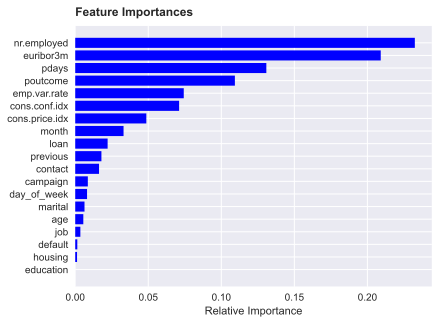

In [31]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

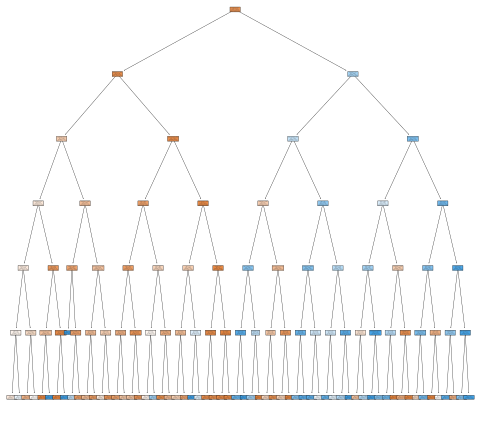

In [32]:
from sklearn import tree
import matplotlib.pyplot as plt
fn= columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
tree.plot_tree(rnd_clf.estimators_[0],
               feature_names = fn,
               filled = True,
              proportion=True);
# fig.savefig('rf_individualtree.png')